In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 25/06/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [5]:
file = project_path +  'data_cut_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [17]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


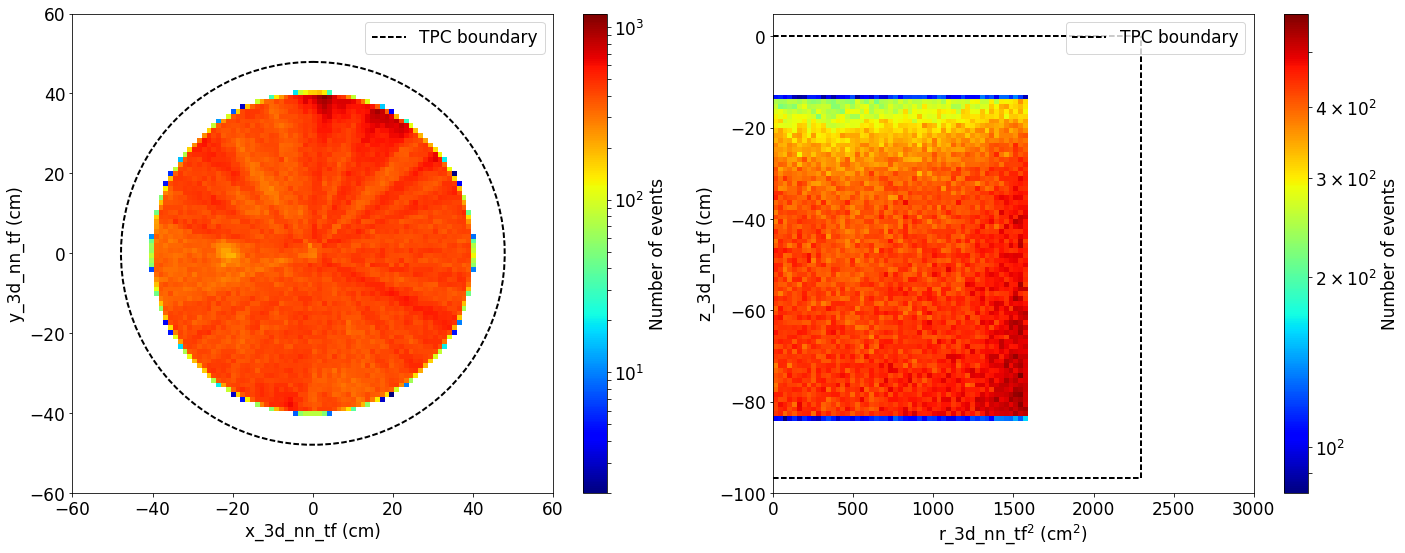

In [18]:
data_distribution(data_white, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


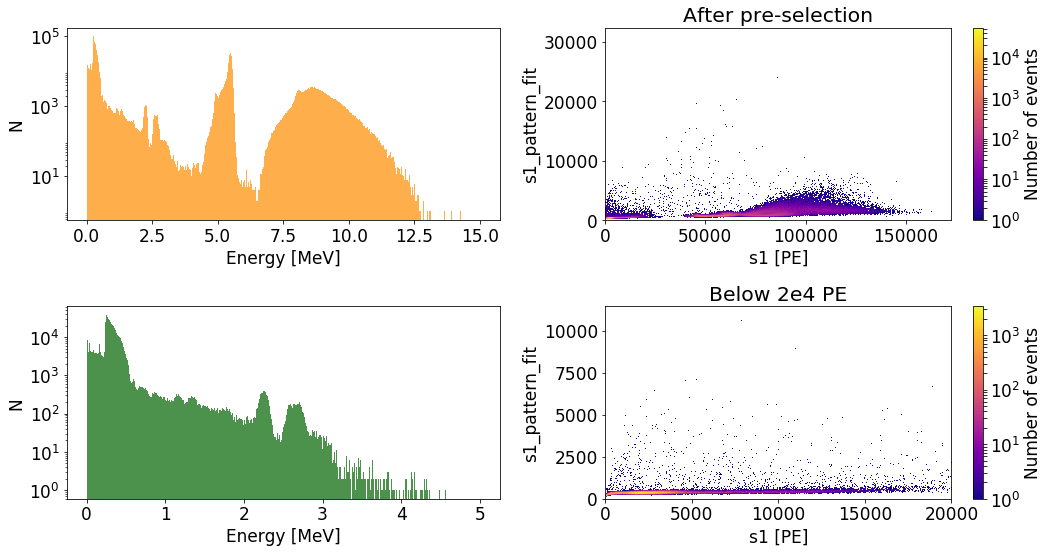

In [24]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')


plt.tight_layout()
plt.show()

### Cut definition 

In [22]:
def S1PatternLikelihoodProfile(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

a = -17.384885
b = 24.894875
c = 2.794984
d = -0.237268
e = 0.005549
init_old = [a, b, c, d, e]

In [23]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def fit_func(x, p0, p1, p2, p3, p4, p5, p6, p7):
    return poly5(x, p0, p1, p2, p3, p4, p5) + inv_poly(x, p6, p7)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

In [26]:
hist, xbins, ybins = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
                                   range=((0,2e4), (0,4500)))
ybins_center = [0.5*(ybins[i]+ybins[i+1]) for i in range(len(ybins)-1)]
xbins_center = [0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)]

In [28]:
perc = np.empty(len(xbins_center))
for i in tqdm(range(len(hist))):
    perc[i] = percentile(index = i, hist=hist, ybins=ybins, xbins=xbins, q=0.99, var1='s1', var2='s1 patter fit hax')


 93%|█████████▎| 926/1000 [01:29<00:07, 10.29it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


In [29]:
init = [ 4.78681704e+02,  1.40005246e-02, -7.12468987e-06,  2.23409109e-09,
         -2.23585862e-13,  7.15271136e-18, -2.14589222e+03,  3.16923133e+03]

xbins_center_valid, perc_valid = dropNaNforFit(xbins_center, perc)
xbins_center_valid, perc_valid = dropNegforFit(xbins_center_valid, perc_valid)
popt, pcov = curve_fit(fit_func, xbins_center_valid, perc_valid, p0=init)
print(init, '\n\n', popt, '\n\n', pcov)

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 7.15271136e-18, -2145.89222, 3169.23133] 

 [  5.11010050e+02  -3.34679248e-03   3.12128281e-06  -5.57013143e-10
   4.43992727e-14  -1.16942969e-18  -2.42964235e+03   3.81357219e+03] 

 [[  2.23759172e+03  -1.10627385e+00   2.52525471e-04  -2.64206653e-08
    1.26673845e-12  -2.25970780e-17  -3.77379284e+04   1.04547285e+05]
 [ -1.10627385e+00   6.28913019e-04  -1.54716311e-07   1.69277139e-11
   -8.35906626e-16   1.52261574e-20   1.70752442e+01  -4.56688258e+01]
 [  2.52525471e-04  -1.54716311e-07   4.00330610e-11  -4.53194256e-15
    2.29284144e-19  -4.25254268e-24  -3.76070728e-03   9.91708870e-03]
 [ -2.64206653e-08   1.69277139e-11  -4.53194256e-15   5.25966561e-19
   -2.71121934e-23   5.10185978e-28   3.86029577e-07  -1.01032536e-06]
 [  1.26673845e-12  -8.35906626e-16   2.29284144e-19  -2.71121934e-23
    1.41812924e-27  -2.69990590e-32  -1.82906412e-11   4.76475367e-11]
 [ -2.25970780e-17   1.52261574e

In [31]:
popt_oldV, pcov_oldV = curve_fit(S1PatternLikelihoodProfile, xbins_center_valid, perc_valid, p0=init_old)
print(init, '\n\n', popt_oldV ,'\n\n', pcov_oldV)

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 7.15271136e-18, -2145.89222, 3169.23133] 

 [  1.30564551e+02   1.97533524e+01  -4.17106327e-01   3.75411282e-03
  -1.14355639e-05] 

 [[  1.20025632e+03  -7.92431739e+01   1.68140319e+00  -1.42696140e-02
    4.20479028e-05]
 [ -7.92431739e+01   5.88079892e+00  -1.33038686e-01   1.17577437e-03
   -3.56292665e-06]
 [  1.68140319e+00  -1.33038686e-01   3.13432335e-03  -2.84878755e-05
    8.81160372e-08]
 [ -1.42696140e-02   1.17577437e-03  -2.84878755e-05   2.64297150e-07
   -8.30427475e-10]
 [  4.20479028e-05  -3.56292665e-06   8.81160372e-08  -8.30427475e-10
    2.64174188e-12]]


In [33]:
params = popt
params_oldV = popt_oldV
x = np.linspace(0, 2e4, 1e4)
y = fit_func(x, *params)
y_oldV = S1PatternLikelihoodProfile(x, *params_oldV)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


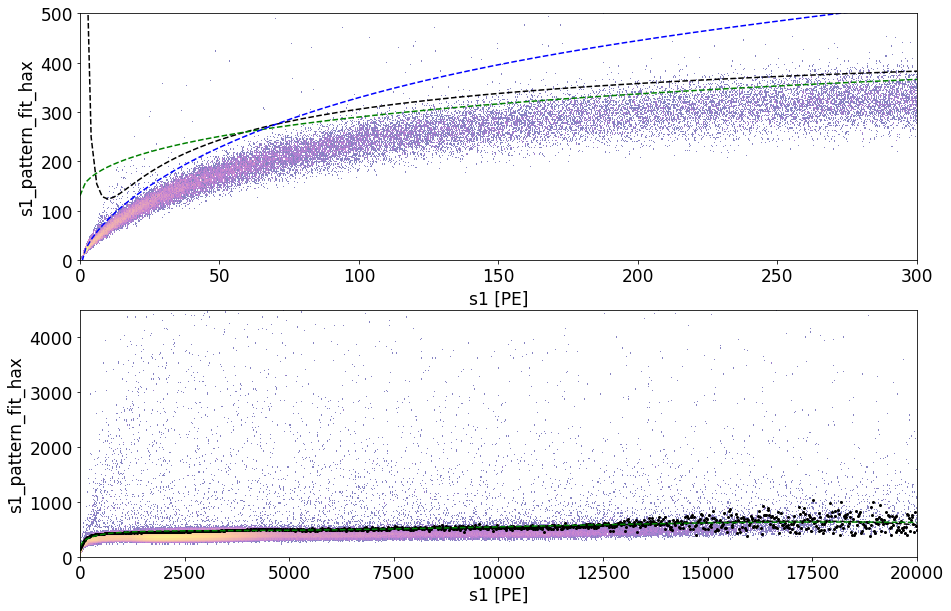

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(211)
#plt.scatter(data['s1'], data['s1_pattern_fit_hax_hax'], s=1, marker='^', c='purple')
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
           range=((0,3e2), (0,500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(x, y, 'k--')
plt.plot(x, y_oldV, 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

#plt.xlim(xmin=0, xmax=300)
#plt.ylim(ymin=0, ymax=500)
plt.subplot(212)
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
           range=((0,2e4), (0,4500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
#plt.colorbar(label='Number of events')
plt.plot(xbins_center_valid, perc_valid, 'ko', ms=2)
plt.plot(xbins_center_valid, fit_func(xbins_center_valid, *popt), 'k--')
plt.plot(xbins_center_valid, S1PatternLikelihoodProfile(xbins_center_valid, *popt_oldV), 'g--')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


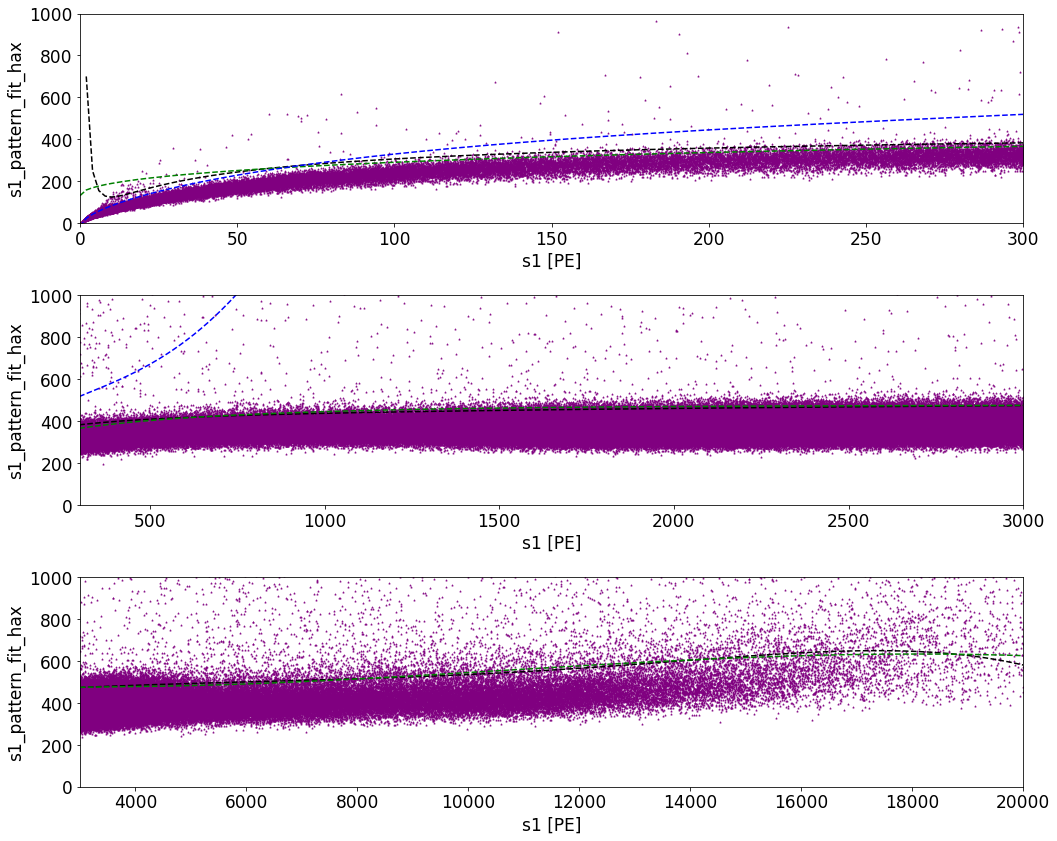

In [39]:
plt.figure(figsize=(15,12))
x = np.linspace(0, 2e4, 1e4)

plt.subplot(311)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(0,300)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(312)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(300,3000)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(313)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(3000,2e4)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()

### Cut definition 2

In [53]:
def cut_v2(x, a, b, c, d, e, f):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2) + f * x**3 

a = -17.384885
b = 24.894875
c = 2.794984
d = -0.237268
e = 0.005549
f = 1
init_v2 = [a, b, c, d, e, f]

In [43]:
hist_v2, xbins_v2, ybins_v2 = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
                                   range=((0,2e4), (0,4500)))
ybins_center_v2 = [0.5*(ybins_v2[i]+ybins_v2[i+1]) for i in range(len(ybins_v2)-1)]
xbins_center_v2 = [0.5*(xbins_v2[i]+xbins_v2[i+1]) for i in range(len(xbins_v2)-1)]

In [44]:
perc_v2 = np.empty(len(xbins_center_v2))
for i in tqdm(range(len(hist))):
    perc[i] = percentile(index = i, hist=hist, ybins=ybins, xbins=xbins, q=0.99, var1='s1', var2='s1 patter fit hax')

xbins_center_valid_v2, perc_valid_v2 = dropNaNforFit(xbins_center_v2, perc_v2)
xbins_center_valid_v2, perc_valid_v2 = dropNegforFit(xbins_center_valid_v2, perc_valid_v2)

 92%|█████████▎| 925/1000 [01:34<00:07,  9.81it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 1000/1000 [01:44<00:00,  9.59it/s]


In [54]:
'''init_v2 = [-3.75788619e+00,   7.48828286e-01,  -4.50544309e-02,   1.11193857e-03,
  -1.07592287e-05,   5.06940611e-10,  -1.96390465e-14,   3.28048192e-19]'''
popt_v2, pcov_v2 = curve_fit(cut_v2, xbins_center_valid_v2, perc_valid_v2, p0=init_v2)
print(init_v2, '\n\n', popt_v2, '\n\n', pcov_v2)

[-17.384885, 24.894875, 2.794984, -0.237268, 0.005549, 1] 

 [ -2.62281285e+00   3.49238214e-01  -1.37061428e-02   2.13255074e-04
  -1.23471758e-06   1.51280501e-11] 

 [[  9.81838595e-01  -8.75436033e-02   2.58042619e-03  -3.21230016e-05
    1.54902879e-07  -1.42033052e-12]
 [ -8.75436033e-02   8.76467460e-03  -2.75287577e-04   3.56747242e-06
   -1.76866816e-08   1.68082827e-13]
 [  2.58042619e-03  -2.75287577e-04   9.00177672e-06  -1.19946598e-07
    6.06913152e-10  -5.93071609e-15]
 [ -3.21230016e-05   3.56747242e-06  -1.19946598e-07   1.63120942e-09
   -8.38347937e-12   8.37690161e-17]
 [  1.54902879e-07  -1.76866816e-08   6.06913152e-10  -8.38347937e-12
    4.36204905e-14  -4.43877455e-19]
 [ -1.42033052e-12   1.68082827e-13  -5.93071609e-15   8.37690161e-17
   -4.43877455e-19   4.64514339e-24]]


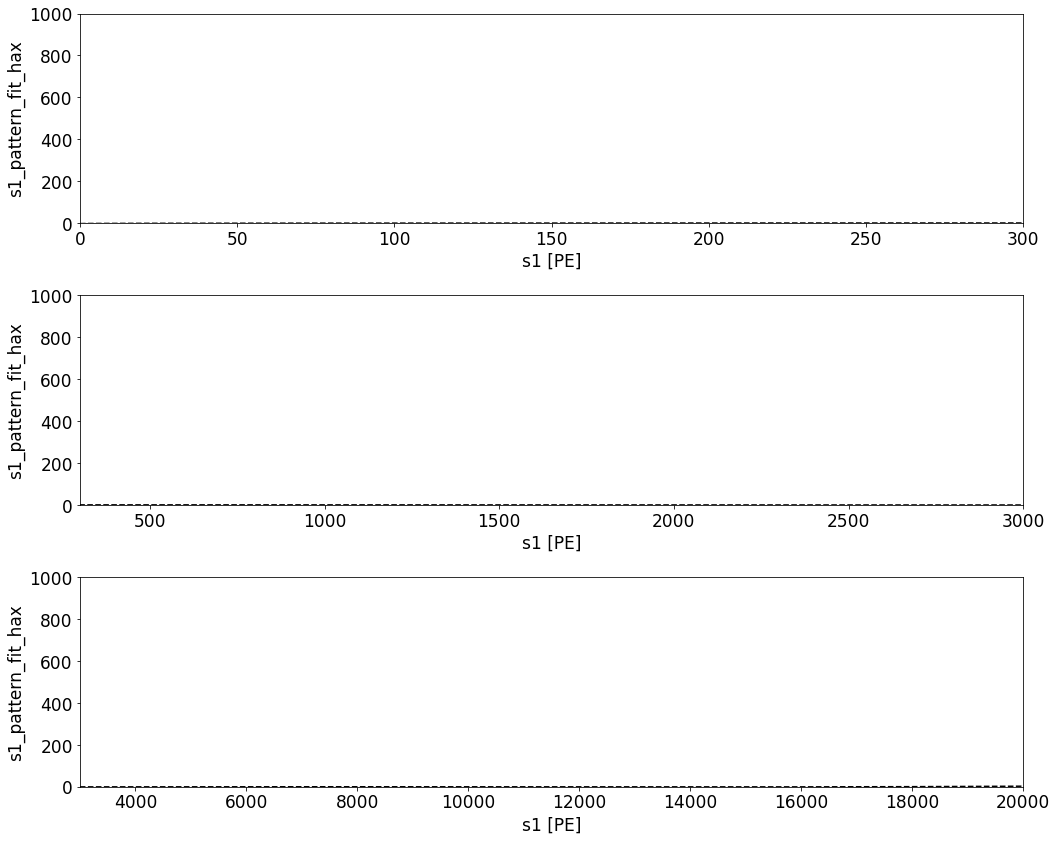

In [55]:
plt.figure(figsize=(15,12))
x = np.linspace(0, 2e4, 1e4)

plt.subplot(311)
#plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, cut_v2(x, *popt_v2), 'k--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(0,300)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(312)
#plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, cut_v2(x, *popt_v2), 'k--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(300,3000)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(313)
#plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, cut_v2(x, *popt_v2), 'k--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
#plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(3000,2e4)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()